In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import base
import numpy as np

MIN_LENGTH = 6
LAST_N = 10


In [2]:
def get_ratio_of_new_frames():
    grouped_users = base.get_dataset_and_group_by_user()

    id_indexes = []
    for i in range(64):
        id_indexes.append('D' + str(i) + '_id')

    success_top = []
    fail_top = []
    success_som = []
    fail_som = []
    for username, group in grouped_users:
        group = base.filter_out_mess(group)
        group_by_target = group.groupby('target_id')

        for target, target_group in group_by_target:
            if target_group.shape[0] < MIN_LENGTH:
                continue
            id_set = set()
            ids = target_group[target_group['type'] != 'guess'][id_indexes]
            result_ratios = []
            for i in range(ids.shape[0]):
                n_of_old_items = len(id_set.intersection(ids.iloc[i]))
                id_set.update(ids.iloc[i])
                n_of_new_items = 64 - n_of_old_items
                ratio = n_of_new_items / 64.0
                result_ratios.append(ratio)
            result_ratios = reversed(list(reversed(result_ratios))[:LAST_N])
            result_ratios = [x for x in result_ratios if x != 1.0]
            if target_group.iloc[0]["display_type"] == "top":
                if target_group[target_group['guess_video'] == target_group['target_video']].empty:
                    fail_top.append(result_ratios)
                else:
                    success_top.append(result_ratios)
            else:
                if target_group[target_group['guess_video'] == target_group['target_video']].empty:
                    fail_som.append(result_ratios)
                else:
                    success_som.append(result_ratios)
    success_top_pd = pd.DataFrame(success_top)
    fail_top_pd = pd.DataFrame(fail_top)
    success_som_pd = pd.DataFrame(success_som)
    fail_som_pd = pd.DataFrame(fail_som)
    return success_top_pd,success_som_pd,fail_top_pd,fail_som_pd


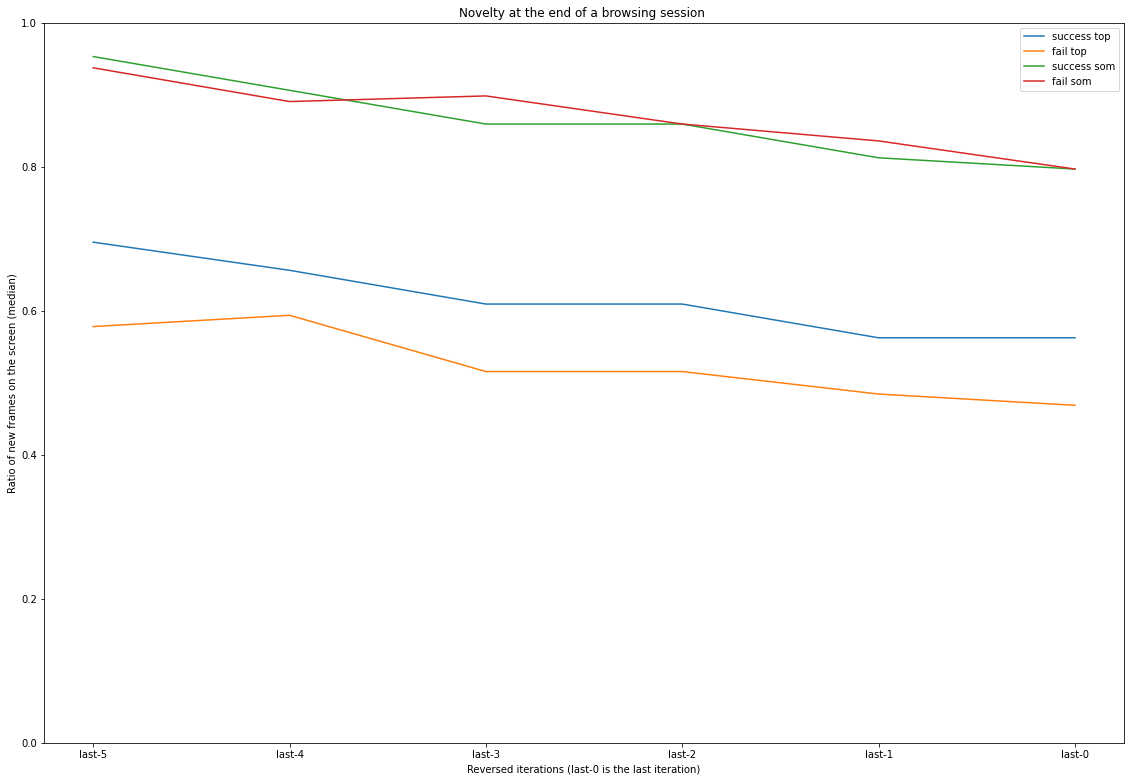

<Figure size 1440x1440 with 0 Axes>

In [3]:
%matplotlib inline
fig, ax = plt.subplots()
success_df_top, success_df_som, fail_df_top, fail_df_som = get_ratio_of_new_frames()
success_df_top = success_df_top.median(axis=0)[:MIN_LENGTH]
success_df_som = success_df_som.median(axis=0)[:MIN_LENGTH]
fail_df_top = fail_df_top.median(axis=0)[:MIN_LENGTH]
fail_df_som = fail_df_som.median(axis=0)[:MIN_LENGTH]
success_df_top.plot.line(label="success top")
fail_df_top.plot.line(label="fail top")
success_df_som.plot.line(label="success som")
fail_df_som.plot.line(label="fail som")


plt.legend(loc="upper right")
plt.title("Novelty at the end of a browsing session ")
plt.xlabel('Reversed iterations (last-0 is the last iteration)')
plt.ylabel('Ratio of new frames on the screen (median)')
plt.ylim(ymin=0, top=1)
plt.xticks(list(range(MIN_LENGTH)), reversed(["last-" + str(i) for i in range(MIN_LENGTH)]))

plt.figure(figsize=(20,20))
fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

plt.show()

In [4]:
def get_difference_between_current_frames_and_most_similar_yet_seen_frame():
    grouped_users = base.get_dataset_and_group_by_user()

    success_top = []
    fail_top = []
    success_som = []
    fail_som = []
    id_indexes = []

    for i in range(64):
        id_indexes.append('D' + str(i) + '_distance_to_target')

    for username, group in grouped_users:
        group = base.filter_out_mess(group)
        # same objects have distance equal to 0
        group_by_target = group.groupby('target_id')

        for target, target_group in group_by_target:
            # we take only sessions longer than 7, we want to know how relevance behaves in a long-term perspective
            if target_group.shape[0] < MIN_LENGTH:
                continue
            min_distance = 1
            distances = target_group[id_indexes]
            result_ratios = []
            for i in range(target_group.shape[0]):
                new_distances = distances.iloc[i]
                difference = new_distances.sub(min_distance)
                if new_distances.min() < min_distance:
                    min_distance = new_distances.min()
                result_ratios.append(difference.median(axis=0))
            result_ratios = reversed(list(reversed(result_ratios))[:MIN_LENGTH])

            if target_group.iloc[0]["display_type"] == "top":
                if target_group[target_group['guess_video'] == target_group['target_video']].empty:
                    fail_top.append(result_ratios)
                else:
                    success_top.append(result_ratios)
            else:
                if target_group[target_group['guess_video'] == target_group['target_video']].empty:
                    fail_som.append(result_ratios)
                else:
                    success_som.append(result_ratios)
    success_top_pd = pd.DataFrame(success_top).median(axis=0)
    fail_top_pd = pd.DataFrame(fail_top).median(axis=0)
    success_som_pd = pd.DataFrame(success_som).median(axis=0)
    fail_som_pd = pd.DataFrame(fail_som).median(axis=0)
    return success_top_pd, success_som_pd, fail_top_pd, fail_som_pd


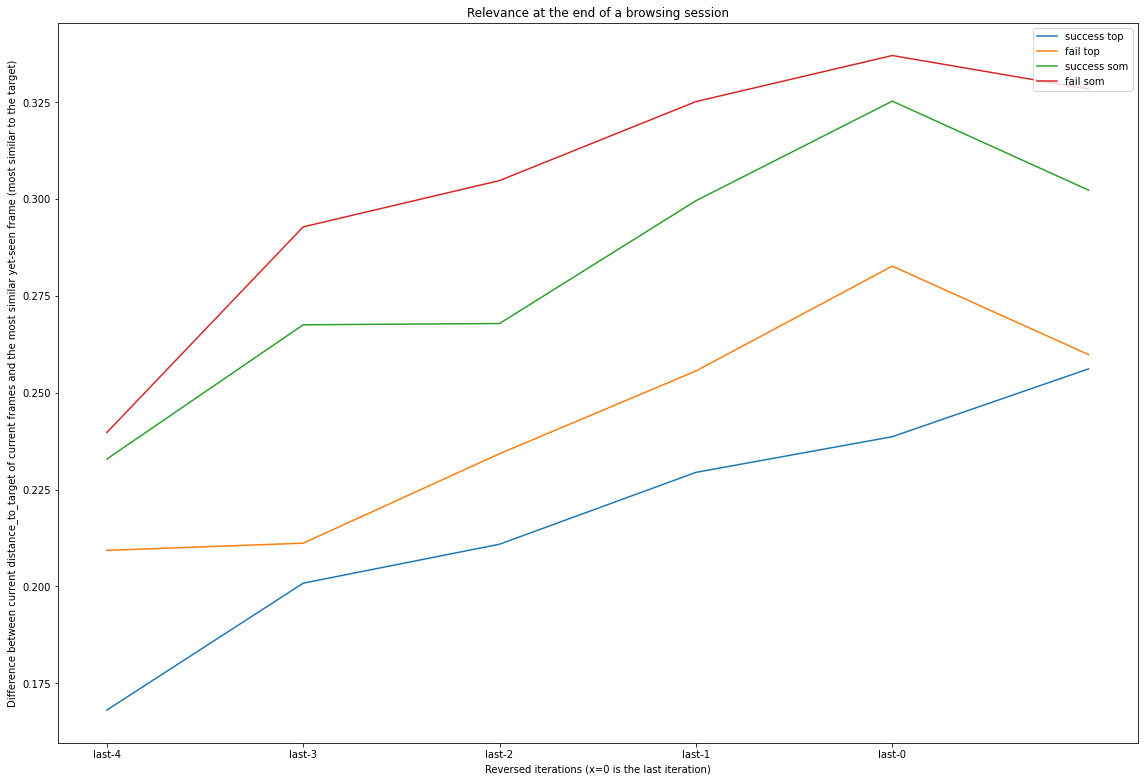

<Figure size 1440x1440 with 0 Axes>

In [5]:
# Hypothese: Users gave up too early - relevance was increasing in the last few iterations, users converged to the target frame

%matplotlib inline
fig, ax = plt.subplots()
success_df_top, success_df_som, fail_df_top, fail_df_som = get_difference_between_current_frames_and_most_similar_yet_seen_frame()

success_df_top.plot.line(label="success top")
fail_df_top.plot.line(label="fail top")
success_df_som.plot.line(label="success som")
fail_df_som.plot.line(label="fail som")

plt.legend(loc="upper right")
plt.title("Relevance at the end of a browsing session")
plt.xlabel('Reversed iterations (x=0 is the last iteration)')
plt.ylabel('Difference between current distance_to_target of current frames and the most similar yet-seen frame (most similar to the target)')
plt.xticks(list(range(5)), reversed(["last-" + str(i) for i in range(5)]))

plt.figure(figsize=(20,20))
fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

plt.show()

/tmp/ipykernel_22259/3830336082.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result_success_top, result_success_som, result_fail_top, result_fail_som = pd.Series(),pd.Series(),pd.Series(),pd.Series()


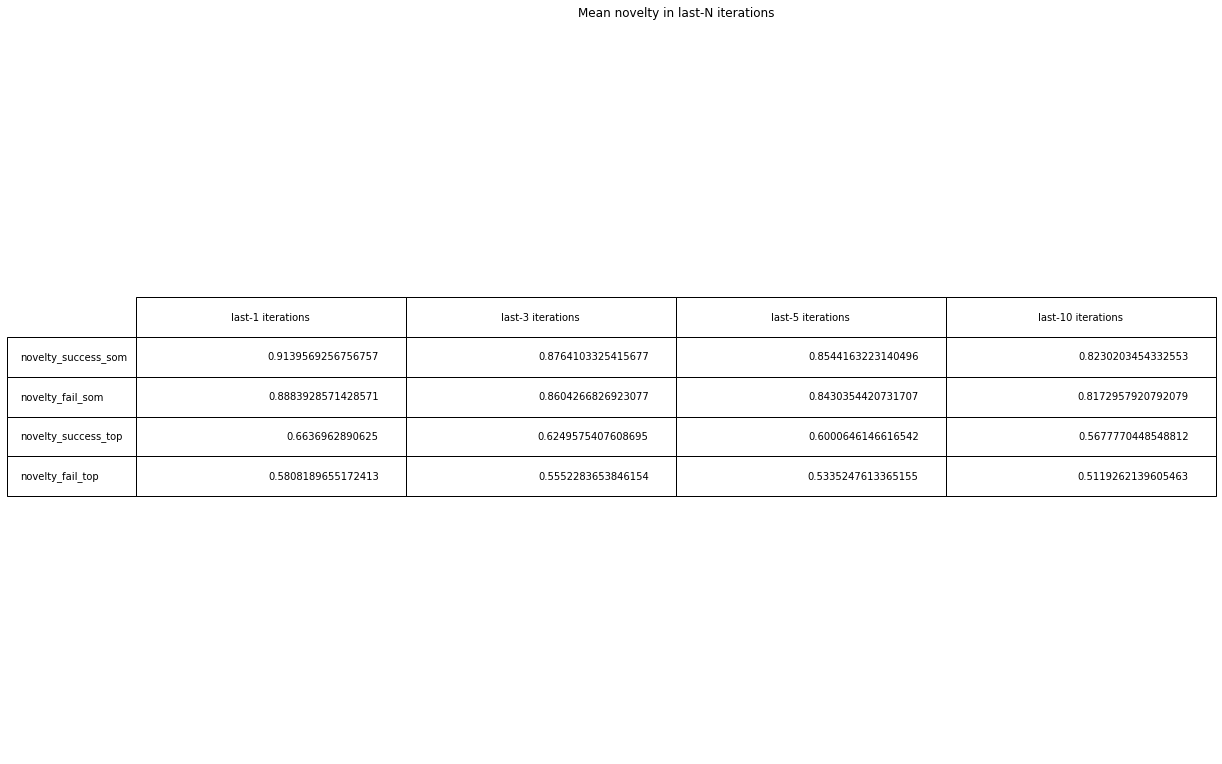

<Figure size 1440x1440 with 0 Axes>

In [7]:
%matplotlib inline
success_df_top, success_df_som, fail_df_top, fail_df_som = get_ratio_of_new_frames()

lasts = [1,3,5,LAST_N]
results = None
for i in lasts:
    result_success_top, result_success_som, result_fail_top, result_fail_som = pd.Series(),pd.Series(),pd.Series(),pd.Series()
    for ii in range(i):
        result_success_som = result_success_som.append(success_df_som.iloc[:,ii])
        result_success_top = result_success_top.append(success_df_top.iloc[:,ii])
        result_fail_top = result_fail_top.append(fail_df_top.iloc[:,ii])
        result_fail_som = result_fail_som.append(fail_df_som.iloc[:,ii])
    medians = np.array([result_success_som.mean(),result_fail_som.mean(),result_success_top.mean(),result_fail_top.mean()])
    if results is None:
        results = medians
    else:
        results = np.vstack((results, medians))
rowLabels = ['novelty_success_som', 'novelty_fail_som', 'novelty_success_top', 'novelty_fail_top']
colLabels = ['last-'+str(i)+' iterations' for i in lasts]
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=results.T,rowLabels=rowLabels,colLabels=colLabels,loc='center')


plt.title("Mean novelty in last-N iterations",pad=20)

plt.figure(figsize=(20,20))
fig.subplots_adjust(0,0,2.5,2.5) # make plots bigger in Jupyter

plt.show()